In [2]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os,sys
import urllib.request
from scipy import interpolate
from scipy.stats import norm
import csv
import yaml
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling import models, fitting
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astroquery.esasky import ESASky
from astropy.nddata import Cutout2D
from astropy import wcs
import pickle as pk
import pandas as pd
import seaborn as sns


%matplotlib inline

In [3]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)



In [4]:
def central_emission(hmap, map_w, pixel_w, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    
    emission = 0
    div = 0
    
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                emission += hmap[i,j]
                div +=1
    return emission, div

In [5]:
def hersch_stacker(hmap, freq, ras, decs, width):
    stack = 0
    divisor = 0
    width = int(width)
    freq = freq
    hmap = hmap
    
    print(freq,hmap)

    hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/HATLAS_{}_BACKSUB{}.FITS'.format(hmap,freq))
    w = wcs.WCS(hi_data[0].header)
    for i in range(len(ras)):
        px, py = w.wcs_world2pix(ras[i], decs[i], 1)
        if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
            continue
        px = np.round(px).astype(int)
        py = np.round(py).astype(int)
        try:
            cutout = Cutout2D(hi_data[0].data, (px,py), width *2, mode = 'strict')
        except:
            continue
        stamp = cutout.data

        if not np.any(stamp):
            continue
    
        if stamp.shape != (2*width, 2*width):
            continue

        stack += stamp
        divisor += 1

    if divisor == 0:
        return
    stack /= divisor

    fig = plt.figure()

    bound = width*0.001667*60

    plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
    plt.colorbar()
    plt.title('MaDCoWS Clusters in {} {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
    plt.xlabel('RA (arcmin)')
    plt.ylabel('Dec (arcmin)')
    plt.savefig('./plots/herschel/{}_{}_mdcw.pdf'.format(hmap, freq))
    plt.savefig('./plots/herschel/{}_{}_mdcw.png'.format(hmap, freq), dpi = 300)
    plt.show()
    plt.close()

In [6]:
def filt_hersch_stacker(hmap, freq, ras, decs, width):
    stack = 0
    divisor = 0
    width = int(width)
    freq = freq
    hmap = hmap
    
    print(freq,hmap)

    hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/filtered/HATLAS_{}_FILT_BACKSUB{}.FITS'.format(hmap,freq))
    w = wcs.WCS(hi_data[0].header)
    for i in range(len(ras)):
        px, py = w.wcs_world2pix(ras[i], decs[i], 1)
        if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
            continue
        px = np.round(px).astype(int)
        py = np.round(py).astype(int)
        try:
            cutout = Cutout2D(hi_data[0].data, (px,py), width *2, mode = 'strict')
        except:
            continue
        stamp = cutout.data

        if not np.any(stamp):
            continue
    
        if stamp.shape != (2*width, 2*width):
            continue
        
        stack += stamp
        divisor += 1

    if divisor == 0:
        return
    stack /= divisor

    fig = plt.figure()

    bound = width*0.001667*60

    plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
    plt.colorbar()
    plt.title('MaDCoWS Clusters in {} Filtered {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
    plt.xlabel('RA (arcmin)')
    plt.ylabel('Dec (arcmin)')
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.savefig('./plots/herschel/filt_{}_{}_mdcw.pdf'.format(hmap, freq))
    plt.savefig('./plots/herschel/filt_{}_{}_mdcw.png'.format(hmap, freq), dpi = 300)
    plt.show()
    plt.close()
    
    cent_scale = 4
    
    center_mean = np.mean(stack[width - cent_scale:width + cent_scale -1,width - cent_scale:width + cent_scale -1])
                            
    print('{} Filtered {} $\mu$m has mean {}'.format(hmap, freq, center_mean))

In [7]:
def filt_full_hersch_stacker(freq, ras, decs, name, clusternames, weight = True, width = 50., zs = None, plot = True):
    stack = 0
    z = 0
    zdiv = 0
    divisor = 0
    width = int(width)
    freq = freq
    name = str(name)
    
    #Poorly named variable: not the beam size but the aperture over which we average emission and associate with a cluster
    beam = 2.4
    
    #print(freq)
    return_names = []
    hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']

    for hmap in hmaps:
        #Gama12 250 header currently bugged, temporarily just skip
        #if freq == '250' and hmap == 'GAMA12_DR1':
        #    continue

        print('Loading map {} {}'.format(hmap, freq), end = '\r')
        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_1.0SMOOTH.fits'.format(hmap,freq))
        
        w = wcs.WCS(hi_data[0].header)
        #print('Map {} {} loaded'.format(hmap, freq), end = '\r')
        
        hdata = hi_data[0].data
        
        for i in range(len(ras)):
            print(round(i/len(ras),2), end =  '\r')
            px, py = w.wcs_world2pix(ras[i], decs[i], 1)
            if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
                continue
            px = np.round(px).astype(int)
            py = np.round(py).astype(int)
            try:
                cutout = Cutout2D(hdata, (px,py), width *2, mode = 'strict')
            except:
                continue
            stamp = cutout.data

            if not np.any(stamp):
                continue
            if stamp[width, width] ==0:
                continue
            if stamp.shape != (2*width, 2*width):
                continue
            
            if weight:
            
                weight_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/filtered/HATLAS_{}_FILT_SIGMA{}.FITS'.format(hmap,freq))
                weight_w = wcs.WCS(weight_data[0].header)

                weight_px, weight_py = weight_w.wcs_world2pix(ras[i], decs[i], 1)
                weight_px = np.round(weight_px).astype(int)
                weight_py = np.round(weight_py).astype(int)

                weight_val = weight_data[0].data[weight_px,weight_py]

                if weight_val <= 10**-20:
                    continue
            else:
                weight_val = 1

            if zs is not None:
                if zs[i] < 100 and not np.isnan(zs[i]):
                    z += zs[i]
                    zdiv += 1
            
            stack += stamp/weight_val
            divisor += 1/weight_val
            return_names.append(clusternames[i])


    if divisor == 0:
        return
    stack /= divisor
    if zdiv != 0:
        z/= zdiv
    else:
        z = None
    print(divisor)
        
    #Calculate mean surface brighness within 0.9' and convert from MJy/beam to MJy/sr

    
    header = hi_data[0].header

    cdelt = header.get('CDELT2', 1.0)

    pixel_size = cdelt*60*u.arcmin

    em, num = central_emission(stack, 50, pixel_size.value, beam/2)

    em = em*u.Jy
    em = em.to(u.MJy)

    pixel_area = ((pixel_size)**2).to(u.sr)


    mean_cent_em = em/(num*pixel_area)
    map_var_Jy = np.std(stack[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
    map_var = (map_var_Jy).to(u.MJy/u.sr) 
    
    if plot:
    
        #Plot the stack
        fig, axes = plt.subplots()

        bound = width*pixel_size.value

        plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])

        #plt.title('{} Clusters at {} $\mu$m, {} in Stack  with z = {:0.3}\n {:0.2e} $\pm$ {:0.2e} MJy/sr central emission'.format(name, 
        #                                        freq, divisor, z, mean_cent_em.value, map_var.value))
        #plt.xlabel('RA (arcmin)')
        #plt.ylabel('Dec (arcmin)')
        #plt.scatter(0,0, marker = '+', color = 'r')
        draw_circle = plt.Circle((0, 0), beam/2, color = 'r',fill=False, alpha = 0.5)
        axes.set_aspect(1)
        axes.add_artist(draw_circle)
        
        #cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
        bar = plt.colorbar(format=ticker.FuncFormatter(fmt))
        
        #bar.set_label('Surface Brightness, MJy/pixel', rotation=270, labelpad = 5.0)
        plt.clim(vmax = 35e-5)
        plt.savefig('./plots/herschel/smooth_1.0_full_filt_{}_{}.pdf'.format(freq, name))
        plt.savefig('./plots/herschel/smooth_1.0_full_filt_{}_{}.png'.format(freq, name), dpi = 300)

        plt.show()
        plt.close()


                            
    #print('Filtered {} $\mu$m has mean {}'.format(freq, center_mean))
    return stack, mean_cent_em, map_var, return_names

In [8]:
def hersch_stamper(freq, ras, decs, width, names):

    stack = 0
    z = 0
    zdiv = 0
    divisor = 0
    width = int(width)
    freq = freq
    stamps = {}

    #print(freq)
    
    hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']

    for hmap in hmaps:
        #Gama12 250 header currently bugged, temporarily just skip
        if freq == '250' and hmap == 'GAMA12_DR1':
            continue

        #print('Loading map {} {}'.format(hmap, freq), end = '\r')
        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_1.0SMOOTH.fits'.format(hmap,freq))
        
        w = wcs.WCS(hi_data[0].header)
        #print('Map {} {} loaded'.format(hmap, freq), end = '\r')
        
        hdata = hi_data[0].data
        
        for i in range(len(ras)):
            print(round(i/len(ras),2), end =  '\r')
            px, py = w.wcs_world2pix(ras[i], decs[i], 1)
            if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
                continue
            px = np.round(px).astype(int)
            py = np.round(py).astype(int)
            try:
                cutout = Cutout2D(hdata, (px,py), width *2, mode = 'strict')
            except:
                continue
            stamp = cutout.data

            if not np.any(stamp):
                continue
            if stamp[width, width] ==0:
                continue
            if stamp.shape != (2*width, 2*width):
                continue
                
            header = hi_data[0].header

            cdelt = header.get('CDELT2', 1.0)

            pixel_size = cdelt*60*u.arcmin
            stamps[names[i]] = [stamp, pixel_size]

            """
            fig = plt.figure()

            bound = width*wcs.utils.proj_plane_pixel_scales(w)[0]*60

            center_mean = np.mean(stamp[width - cent_scale:width + cent_scale -1,width - cent_scale:width + cent_scale -1])*10**3

            plt.imshow(stamp, origin='lower', cmap=plt.cm.viridis, vmin = -20*10**-3, vmax = 20*10**-3, extent = [-bound,bound, -bound,bound])
            plt.colorbar()
            plt.title('{} in {} Filtered {} $\mu$m \n {:0.3e} mJy/sr central emission'.format(names[i], hmap, freq, center_mean))
            plt.xlabel('RA (arcmin)')
            plt.ylabel('Dec (arcmin)')
            plt.scatter(0,0, marker = '+', color = 'r')

            plt.savefig('./plots/herschel/indv_clusters/filt_{}_{}.pdf'.format(freq, names[i].replace(' ', '_')))
            plt.savefig('./plots/herschel/indv_clusters/filt_{}_{}.png'.format(freq, names[i].replace(' ', '_')), dpi = 300)
            plt.show()
            plt.close()
            """
    return stamps

In [7]:
#hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_0.9FILT.fits'.format('GAMA15_DR1',250))
#w = wcs.WCS(hi_data[0].header)

#bound = 1e-2
#fig = plt.figure()

#fig.add_subplot(111, projection=w)

#plt.imshow(hi_data[0].data[1000:1100, 1000:1100], vmin = -bound, vmax = bound)
#plt.show()

250 GAMA12_DR1


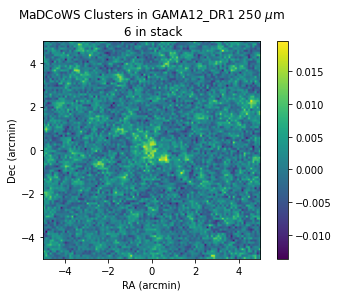

350 GAMA12_DR1


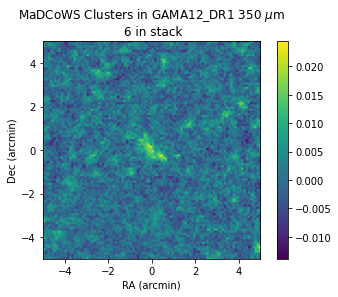

500 GAMA12_DR1


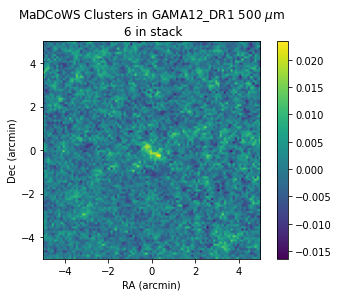

250 GAMA15_DR1


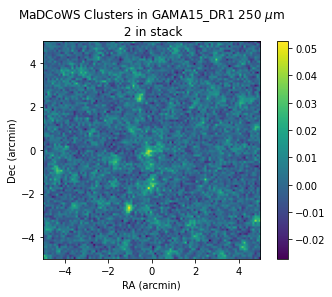

350 GAMA15_DR1


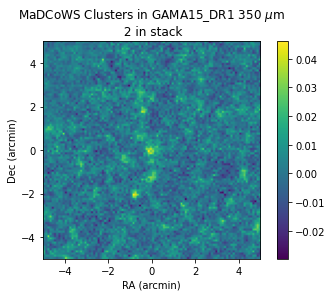

500 GAMA15_DR1


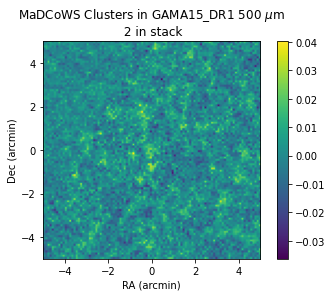

250 GAMA9_DR1


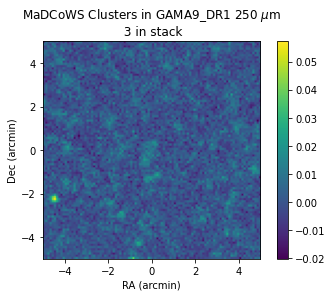

350 GAMA9_DR1


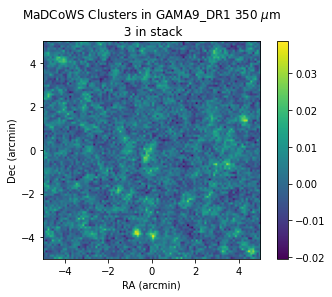

500 GAMA9_DR1


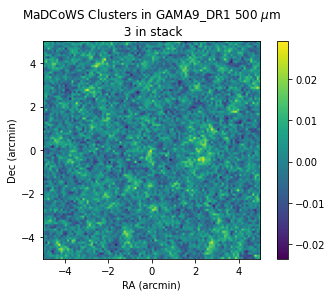

250 NGP_DR2


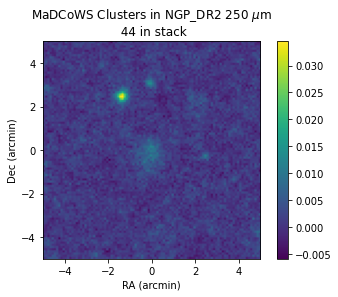

350 NGP_DR2


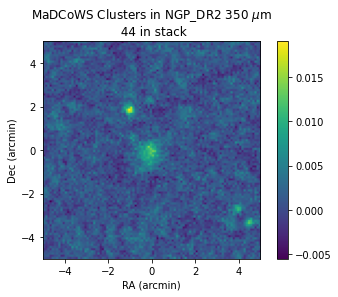

500 NGP_DR2


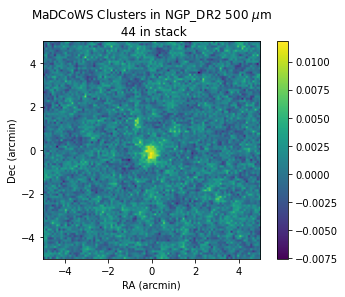

250 SGP_DR2


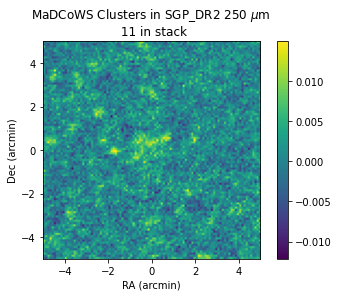

350 SGP_DR2


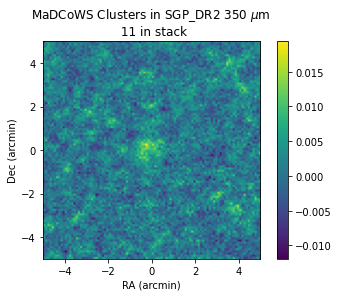

500 SGP_DR2


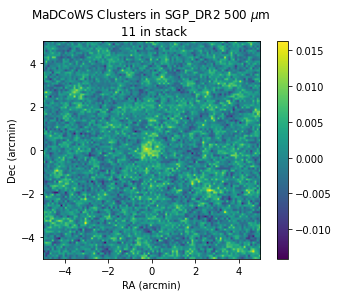

In [14]:
hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']
freqs = ['250', '350', '500']

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ras = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
decs = mdcw_catalog[1].data['decDeg']
ras, decs = np.array(ras), np.array(decs)

for hmap in hmaps:
    for freq in freqs:
        hersch_stacker(hmap, freq, ras, decs, 50.)

In [4]:
hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_NGP_DR2_FILT_BACKSUB500_0.9FILT.fits')
w = wcs.WCS(hi_data[0].header)
print(hi_data[0].header)
hi_data[0].header['CDELT2']*3600*3

print(w.wcs_world2pix(10,10,1))

FileNotFoundError: [Errno 2] No such file or directory: '/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_NGP_DR2_FILT_BACKSUB500_0.9FILT.fits'

In [10]:
herschel_ps =  fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/HATLAS_NGP_DR2_CATALOGUE_V1.4.FITS')

ras = herschel_ps[1].data['RA']
decs = herschel_ps[1].data['DEC']
ras, decs = np.array(ras), np.array(decs)


250 NGP_DR2


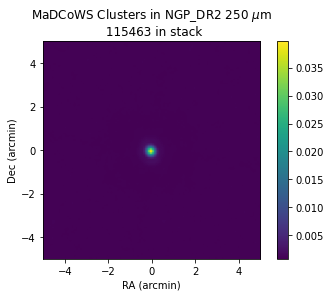

350 NGP_DR2


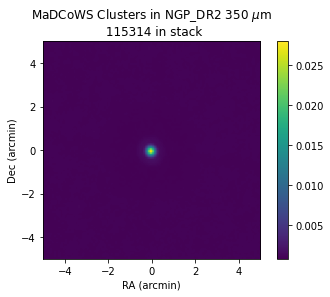

500 NGP_DR2


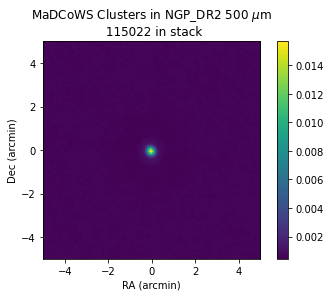

In [11]:

freqs = [ '250', '350', '500']
for freq in freqs:
    hersch_stacker('NGP_DR2', freq, ras, decs, 50.)

In [133]:
px2, py2 = w.wcs_world2pix(ras[1], decs[1], 1)


px2 = np.round(px2).astype(int)
py2 = np.round(py2).astype(int)

#stamp = hi_data[0].data[px-50: px+50, py-50: py+50]

cutout2 = Cutout2D(hi_data[0].data, (px2,py2), 100)

fig.add_subplot(111, projection=w)
plt.imshow(cutout2.data, origin='lower', cmap=plt.cm.viridis, vmax = 1e-2)
plt.title('MaDCoWS Clusters in {} {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
plt.xlabel('RA (arcmin)')
plt.ylabel('Dec (arcmin)')
#plt.savefig('./plots/herschel/{}_{}_filtered_mdcw.pdf'.format(hmap, freq))
#plt.savefig('./plots/herschel/{}_{}_filtered_mdcw.png'.format(hmap, freq), dpi = 300)
plt.show()
plt.close()

NameError: name 'w' is not defined

In [134]:
stack = cutout.data + cutout2.data
stack  /= 2

NameError: name 'cutout' is not defined

In [9]:
hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']
freqs = ['250', '350', '500']

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ras = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
decs = mdcw_catalog[1].data['decDeg']
zs = mdcw_catalog[1].data['Photz']
ras, decs = np.array(ras), np.array(decs)

66.0ing map SGP_DR2 250500


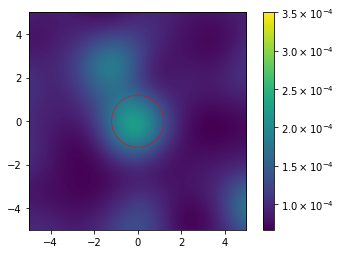

66.0ing map SGP_DR2 350500


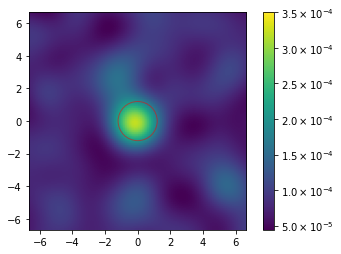

66.0ing map SGP_DR2 500000


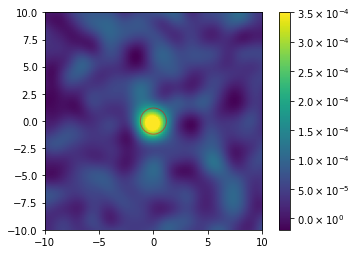

In [10]:
mdcw_stacks = {'250':[], '350':[], '500':[]}
mdcw_stamps = {}

for freq in freqs:
        
    stack, cent, cent_var, HATLAS_names = filt_full_hersch_stacker(freq, ras, decs, 'mdcw', names, width = 50., zs = zs, weight = False)
    mdcw_stacks[freq].append(stack)
    
    stamp = hersch_stamper(freq,ras, decs, 50.,names)
    mdcw_stamps[freq] = stamp
    
        
pk.dump(mdcw_stamps, open('mdcw_stamps.pk', 'wb'))



66.0ing map SGP_DR2 250500


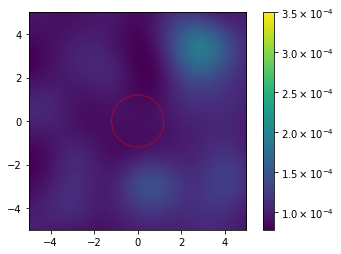

66.0ing map SGP_DR2 350500


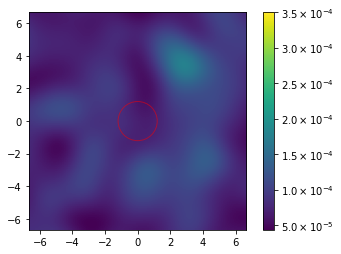

65.0ing map SGP_DR2 500000


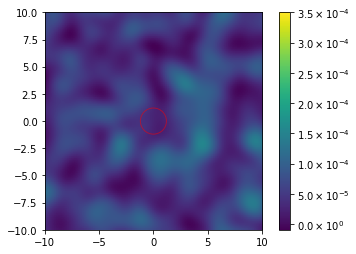

In [11]:
rand_ras, rand_decs = np.zeros(len(ras)), np.zeros(len(ras))

for i in range(len(ras)):
    offset = 5*u.arcmin
    offset = offset.to(u.deg)
    angle = 2*np.pi*np.random.rand()
    rand_ras[i] = ras[i]+np.sin(angle)*offset.value
    rand_decs[i] = decs[i]+np.cos(angle)*offset.value


    
randoms_stacks = {'250':[], '350':[], '500':[]}
randoms_stamps = {}

for freq in randoms_stacks.keys():
        
    stack, cent, cent_var, HATLAS_names = filt_full_hersch_stacker(freq, rand_ras, rand_decs, 'randoms', names, width = 50., zs = zs, weight = False, plot = True)
    randoms_stacks[freq].append(stack)
    
    stamp = hersch_stamper(freq,rand_ras, rand_decs, 50.,names)
    randoms_stamps[freq] = stamp
pk.dump(randoms_stamps, open('randoms_stamps.pk', 'wb'))


In [68]:
flags = [False for i in range(len(names))] 
#print(flags)
for i in range(len(names)):
    if names[i] in HATLAS_names:
        flags[i] = True
print(len(HATLAS_names))
ras, decs, flags, zs =ras[flags], decs[flags], names[flags], zs[flags]

boot_smooth_stacks = {'250':[], '350':[], '500':[]}


for i in range(100):
    print(i, end = '\r')
    flags = np.random.randint(len(ras), size = len(ras))
    
    temp_ras, temp_decs, temp_names, temp_zs = ras[flags], decs[flags], names[flags], zs[flags]


    for freq in freqs:

        stack, cent, cent_var, HATLAS_names = filt_full_hersch_stacker(freq, temp_ras, temp_decs, 'mdcw', temp_names, width = 50., zs = temp_zs, weight = False, plot = False)
        boot_smooth_stacks[freq].append(stack)




pk.dump(boot_smooth_stacks, open('boot_mdcw_stamps.pk', 'wb'))


66
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 250500
66.0ing map SGP_DR2 350500
66.0ing map SGP_DR2 500000
66.0ing map SGP_DR2 25050

0


TypeError: 'NoneType' object is not iterable

In [69]:
cent_means = {'250':[], '350':[], '500':[]}
pixel_scales = {'250': 18/3, '350':25/3, '500':36/3}
for freq in freqs:
    for i in range(len(boot_smooth_stacks[freq])):
        stack = boot_smooth_stacks[freq][i]

        pixel_size = (pixel_scales[freq]*u.arcsec).to(u.arcmin)

        em, num = central_emission(stack, 50, pixel_size.value, 1.2)

        em = em*u.Jy
        em = em.to(u.MJy)

        pixel_area = ((pixel_size)**2).to(u.sr)


        mean_cent_em = em/(num*pixel_area)
        map_var_Jy = np.std(stack[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
        map_var = (map_var_Jy).to(u.MJy/u.sr)

        cent_means[freq].append(mean_cent_em.value)

In [70]:
print('250 error: ', np.std(cent_means['250']))
print('350 error: ', np.std(cent_means['350']))
print('500 error: ', np.std(cent_means['500']))

250 error:  0.013731919579092955
350 error:  0.010656795812965357
500 error:  0.006933129673997633


dict_keys(['MOO J1454+0032', 'MOO J1458-0012', 'MOO J0914-0025', 'MOO J0920+0023', 'MOO J0924+0041', 'MOO J1250+2719', 'MOO J1251+2823', 'MOO J1251+2519', 'MOO J1252+2603', 'MOO J1254+3320', 'MOO J1256+2537', 'MOO J1301+3032', 'MOO J1307+3403', 'MOO J1308+2429', 'MOO J1308+2406', 'MOO J1310+3238', 'MOO J1310+2852', 'MOO J1313+3414', 'MOO J1319+2252', 'MOO J1321+2711', 'MOO J1321+3306', 'MOO J1322+3134', 'MOO J1323+2405', 'MOO J1325+2429', 'MOO J1325+2438', 'MOO J1325+2950', 'MOO J1326+2903', 'MOO J1327+3154', 'MOO J1327+2317', 'MOO J1331+3138', 'MOO J1333+2900', 'MOO J1334+3400', 'MOO J1335+3004', 'MOO J1337+3529', 'MOO J1338+3444', 'MOO J1340+3011', 'MOO J1341+2320', 'MOO J1343+3208', 'MOO J1344+2826', 'MOO J1346+2943', 'MOO J1346+3508', 'MOO J1348+2519', 'MOO J1349+3008', 'MOO J1350+3008', 'MOO J1247+3430', 'MOO J1250+3419', 'MOO J1318+2758', 'MOO J1328+3305', 'MOO J1350+2749', 'MOO J0104-2803', 'MOO J0107-2951', 'MOO J0118-2714', 'MOO J0121-2725', 'MOO J0126-2947', 'MOO J0127-2759',

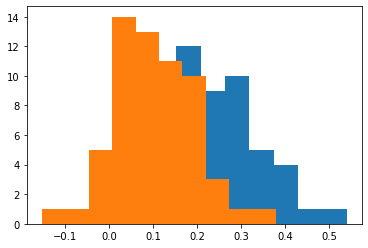

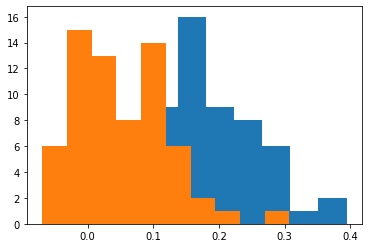

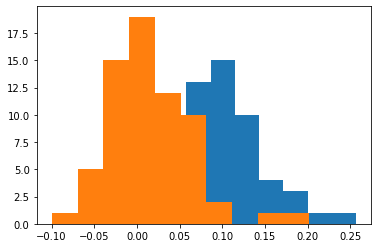

In [44]:
print(randoms_stamps['250'].keys())
print(mdcw_stamps['250'].keys())


#good_names = []
#sigmas = []

mdcw_cent_ems = {'250':[], '350':[], '500':[]}
rand_cent_ems = {'250':[], '350':[], '500':[]}

beam = 2.4

for key in cent_ems.keys():
    stamps = mdcw_stamps[key]
    rand_stamps = randoms_stamps[key]
    for cluster_name in stamps.keys():
        stamp, pixel_size = stamps[cluster_name][0], stamps[cluster_name][1]
        rand_stamp, pixel_size = rand_stamps[cluster_name][0], stamps[cluster_name][1]

        #plt.imshow(stamp)
        #plt.show()
        #plt.close()

        #print(pixel_size)
        em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)

        em_rand, num = central_emission(rand_stamp, 50, pixel_size.value, beam/2)
        em_rand = em_rand*u.Jy
        em_rand = em_rand.to(u.MJy)
        
        pixel_area = (pixel_size)**2
        pixel_area = pixel_area.to(u.sr)

        mean_cent_em = em/(num*pixel_area)
        rand_mean_cent_em = em_rand/(num*pixel_area)


        mdcw_cent_ems[key].append(mean_cent_em.value)
        rand_cent_ems[key].append(rand_mean_cent_em.value)

        #map_var_Jy = np.std(stamp[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
        #map_var = (map_var_Jy).to(u.MJy/u.sr) 


        #if mean_cent_em/map_var > 4:
            #print(mean_cent_em/map_var)
            #good_names.append(key)  
            #sigmas.append(mean_cent_em/map_var)
            
for key in cent_ems.keys():
    plt.hist(np.array(mdcw_cent_ems[key]))

    plt.hist(np.array(rand_cent_ems[key]))
    plt.show()

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale        
            K                 MJy / sr      
    ------------------ ---------------------
    23.857458126389535 1.643260516112612e-07


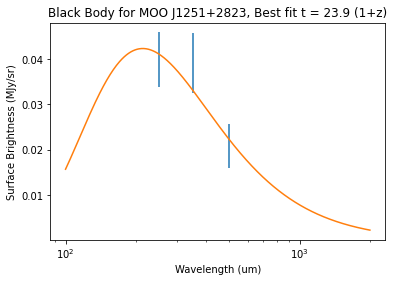

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             x_0                alpha       
          MJy / sr             GHz                            
    ------------------- ------------------ -------------------
    0.04216800802056307 1209.0844369256022 -0.9038539964446292
[5.21463697e+00 8.18230665e-08] sr2 / MJy2


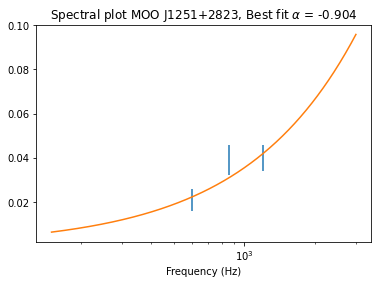

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale         
            K                 MJy / sr       
    ------------------ ----------------------
    367.79524545768555 1.8008117151959136e-09


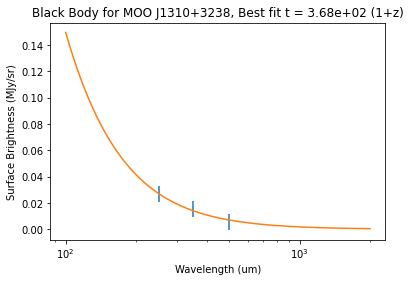

Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               x_0                  alpha       
         MJy / sr               GHz                              
    ------------------ ---------------------- -------------------
    0.6079936529220221 4.5727350076487116e-10 0.13157078183409257


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


ValueError: Input must be 1- or 2-d.

In [11]:
ts = []
indecies = []
t_errs = []

for name in good_names:
    MJys = []
    MJys_err = []
    fit_freqs = np.array([250, 350, 500])*u.um
    
    for freq in ['250', '350', '500']:
        stamps = mdcw_stamps[freq]
        stamp, pixel_size = stamps[name][0], stamps[name][1]*60*u.arcmin
        
        em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)

        pixel_area = (pixel_size)**2
        pixel_area = pixel_area.to(u.sr)

        mean_cent_em = em/(num*pixel_area)
        map_var_Jy = np.std(stamp[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
        map_var = (map_var_Jy).to(u.MJy/u.sr) 
        
        MJys_err.append(map_var.value)
        MJys.append(mean_cent_em.value)
        
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-8 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()
    MJys_err = np.array(MJys_err)*u.MJy/u.sr

    
    best_fit = fitter(model, fit_freqs, MJys, weights=1.0/MJys_err**2)
    #scales.append(best_fit.scale.value)
    print(best_fit)
    try:
        cov_diag = np.diag(fitter.fit_info['param_cov'])
    except:
        cov_diag = [0*u.K]
    
    
    

    wav = np.arange(100, 2000) * u.um
    flux = best_fit(wav).to(u.MJy/u.sr)


    plt.figure()
    plt.title('Black Body for {}, Best fit t = {:0.3} (1+z)'.format(name, best_fit.temperature.value))
    plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Wavelength (um)')
    plt.ylabel("Surface Brightness (MJy/sr)")
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close
    
    ts.append(best_fit.temperature.value)
    t_errs.append(cov_diag[0].value)
    
    #Fit for spectral index
    power_law = models.PowerLaw1D(x_0 = 2000)
    fit = fitting.LevMarLSQFitter()
    fitted_power = fit(power_law,fit_freqs.to(u.GHz, equivalencies=u.spectral()), MJys, weights=1.0/MJys_err**2)
                      
    print(fitted_power)
    
    cov_diag = np.diag(fitter.fit_info['param_cov'])
    print(np.sqrt(cov_diag))
    
    wav = np.arange(100, 2000) * u.um
    wav = wav.to(u.GHz, equivalencies=u.spectral())
    flux = fitted_power(wav)


    plt.figure()
    plt.title(r'Spectral plot {}, Best fit $\alpha$ = {:0.3} '.format(name, fitted_power.alpha.value))
    plt.errorbar(fit_freqs.to(u.GHz, equivalencies=u.spectral()).value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Frequency (Hz)')
    
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    
    plt.savefig('./plots/herschel/indv_clusters/spectral_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/spectral_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close

In [316]:
print(good_names,sigmas, ts)

['MOO J1454+0032', 'MOO J1251+2823', 'MOO J1254+3320', 'MOO J1256+2537', 'MOO J1310+3238', 'MOO J1319+2252', 'MOO J1321+2711', 'MOO J1322+3134', 'MOO J1327+2317', 'MOO J1333+2900', 'MOO J1335+3004', 'MOO J1337+3529', 'MOO J1340+3011', 'MOO J1344+2826', 'MOO J1247+3430', 'MOO J1328+3305', 'MOO J0118-2714', 'MOO J0127-2759', 'MOO J0139-3120'] [<Quantity 4.3201912>, <Quantity 8.07561799>, <Quantity 4.19252924>, <Quantity 4.87153639>, <Quantity 4.69597901>, <Quantity 5.66604954>, <Quantity 4.51179547>, <Quantity 4.35347974>, <Quantity 4.83826277>, <Quantity 6.80957386>, <Quantity 10.80070189>, <Quantity 4.24018245>, <Quantity 4.27802407>, <Quantity 4.90470917>, <Quantity 4.83422833>, <Quantity 5.2481736>, <Quantity 11.71072614>, <Quantity 6.52618126>, <Quantity 4.49094005>] [3093.6902458619393, 49.902465981369524, 19.34349390635666, 6347.211594942679, 2930.2377386072912, 1775.021769938699, 31.85719200991918, 44.71506294213962, 2291.8103339814343, 212.76545699517987, 29.035611026760066, 69.

0.001666666666667
0.10000000000002 arcmin
8.280452931649052e-08 MJy 448 8.461594994078622e-10 sr
0.002222222222222
0.13333333333332 arcmin
6.291553810297046e-08 MJy 256 1.5042835545019638e-09 sr
0.003333333333333
0.19999999999998 arcmin
3.25097552704392e-08 MJy 112 3.384637997629418e-09 sr
[0.00701    0.21843581 0.16337599 0.08575974] MJy / sr


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    68.32072300079105 1.4157544758021109e-07


NameError: name 'name' is not defined

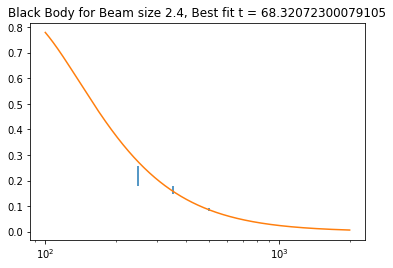

In [9]:
#beams = np.linspace(0.4, 1.5, 10)

beams = [2.4]

infered_t = []
infered_t_err = []

scales = []

for beam in beams:
    MJys = [0.00701]
    MJys_err = np.array([0.000967, 0.0384, 0.0144, 0.00608])*u.MJy/u.sr
    fit_freqs = np.array([1362.69, 250, 350, 500])*u.um
    
    for freq in freqs:

        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_SGP_DR2_FILT_BACKSUB{}_1.0SMOOTH.fits'.format(freq))
        header = hi_data[0].header
        
        cdelt = header.get('CDELT2', 1.0)
        print(cdelt)
        pixel_size = cdelt*60*u.arcmin
        
        print(pixel_size)
        em, num = central_emission(smooth_stacks[freq][0], 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)
        
        pixel_area = ((pixel_size)**2).to(u.sr)
        print(em, num, pixel_area)
        MJys.append((em/(num*pixel_area)).value)
        #print('Emission at {}: {}'.format(freq,em/area))
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-8 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()
    print(MJys)
    
    cut = 1
    
    best_fit = fitter(model, fit_freqs[cut:], MJys[cut:], weights=1.0/MJys_err[cut:]**2)
    scales.append(best_fit.scale.value)
    infered_t.append(best_fit.temperature.value)
    print(best_fit)
    #cov_diag = np.diag(fitter.fit_info['param_cov'])
    #infered_t_err.append(np.sqrt(cov_diag)[0].value)
    
    

    wav = np.arange(100, 2000) * u.um
    flux = best_fit(wav).to(u.MJy/u.sr)


    plt.figure()
    plt.title('Black Body for Beam size {}, Best fit t = {}'.format(beam, best_fit.temperature.value))
    plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close

    #Fit powerlaw
    power_law = models.PowerLaw1D(x_0 = 2000)
    fit = fitting.LevMarLSQFitter()
    print(fit_freqs.to(u.GHz, equivalencies=u.spectral()))
    fitted_power = fit(power_law,fit_freqs.to(u.GHz, equivalencies=u.spectral())[cut:], MJys[cut:], weights=1.0/MJys_err[cut:]**2)
                      
    print(fitted_power)
    
    
    wav = np.arange(200, 600) * u.um
    wav = wav.to(u.GHz, equivalencies=u.spectral())
    flux = fitted_power(wav)
    #cov_diag = np.diag(fit.fit_info['param_cov'])
    print(fit.fit_info['param_cov'])

    plt.figure()
    plt.title(r'MaDCoWS Spectral plot, Best fit $\alpha$ = {:0.3}, Appeture size = {} '.format(fitted_power.alpha.value, beam))
    plt.errorbar(fit_freqs.to(u.GHz, equivalencies=u.spectral()).value[cut:], MJys.value[cut:], yerr = MJys_err.value[cut:], linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Frequency (Hz)')
    
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    plt.xlim()
    plt.savefig('./plots/herschel/mdcw_spectral.pdf')
    plt.savefig('./plots/herschel/mdcw_spectral.png', dpi = 300)
    
    plt.show()
    plt.close

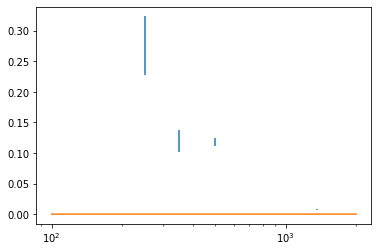

In [235]:
bb = models.BlackBody(temperature=infered_t*u.K, scale = scales)

wav = np.arange(100, 2000) * u.um
flux = bb(wav).to(u.MJy/u.sr)


plt.figure()
plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
plt.semilogx(wav, flux)
#plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')
plt.show()

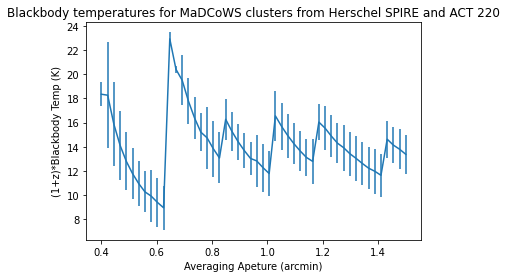

In [145]:

plt.errorbar(beams, infered_t, yerr = infered_t_err)
plt.xlabel('Averaging Apeture (arcmin)')
plt.ylabel('(1+z)*Blackbody Temp (K)')
plt.title('Blackbody temperatures for MaDCoWS clusters from Herschel SPIRE and ACT 220')
plt.savefig('./plots/herschel/blackbody.pdf')
plt.savefig('./plots/herschel/blackbody.png', dpi = 300)
plt.show()

In [13]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ras_act = act_catalog[1].data['RADeg']
names_act = act_catalog[1].data['name']
decs_act = act_catalog[1].data['decDeg']
act_zs = act_catalog[1].data['redshift']
mass = act_catalog[1].data['M500']

print(len(ras_act), len(names_act))

4195 4195


35.0ing map SGP_DR2 250500


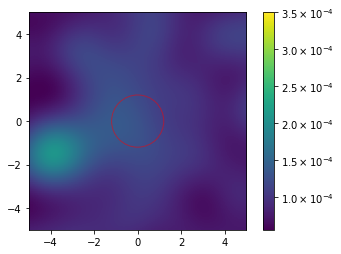

34.0ing map SGP_DR2 350500


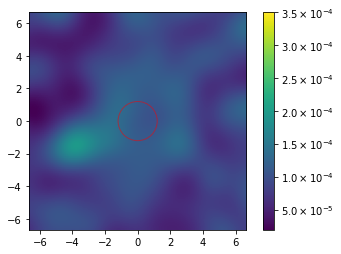

34.0ing map SGP_DR2 500000


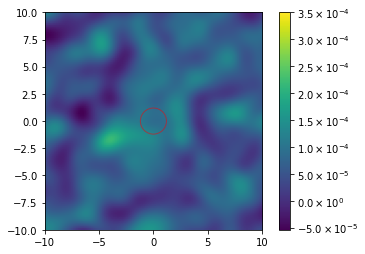

In [14]:
act_smooth_stacks = {'250':[], '350':[], '500':[]}
act_stamps = {}

for freq in act_smooth_stacks.keys():
        
    stack, cent, cent_var, HATLAS_names = filt_full_hersch_stacker(freq, ras_act, decs_act, 'ACT', names_act,  width = 50., weight = False, zs = act_zs)
    act_smooth_stacks[freq].append(stack)
    
    stamp = hersch_stamper(freq,ras_act, decs_act, 50.,names_act)
    act_stamps[freq] = stamp
        
pk.dump(act_stamps, open('act_stamps.pk', 'wb'))

In [74]:
flags = [False for i in range(len(names_act))] 
#print(flags)
for i in range(len(names_act)):
    if names_act[i] in HATLAS_names:
        flags[i] = True

ras_act, decs_act, names_act, act_zs = ras_act[flags], decs_act[flags], names_act[flags], act_zs[flags]
    
print(len(ras_act))
boot_act_stacks = {'250':[], '350':[], '500':[]}


for i in range(100):
    print(i, end = '\r')
    flags = np.random.randint(len(ras_act), size = len(ras_act))
    
    temp_ras, temp_decs, temp_names, temp_zs = ras_act[flags], decs_act[flags], names_act[flags], act_zs[flags]


    for freq in boot_smooth_stacks.keys():

        stack, cent, cent_var, HATLAS_names = filt_full_hersch_stacker(freq, temp_ras, temp_decs, 'ACT', temp_names, width = 50., zs = temp_zs, weight = False, plot = False)
        boot_act_stacks[freq].append(stack)




pk.dump(boot_act_stacks, open('boot_act_stamps.pk', 'wb'))

34
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 250500
34.0ing map SGP_DR2 350500
34.0ing map SGP_DR2 500000
34.0ing map SGP_DR2 25050

In [75]:
act_cent_means = {'250':[], '350':[], '500':[]}
pixel_scales = {'250': 18/3, '350':25/3, '500':36/3}
for freq in boot_act_stacks.keys():
    for i in range(len(boot_act_stacks[freq])):
        stack = boot_act_stacks[freq][i]

        pixel_size = (pixel_scales[freq]*u.arcsec).to(u.arcmin)

        em, num = central_emission(stack, 50, pixel_size.value, 1.2)

        em = em*u.Jy
        em = em.to(u.MJy)

        pixel_area = ((pixel_size)**2).to(u.sr)


        mean_cent_em = em/(num*pixel_area)
        map_var_Jy = np.std(stack[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
        map_var = (map_var_Jy).to(u.MJy/u.sr)

        act_cent_means[freq].append(mean_cent_em.value)

In [76]:
print('ACT 250: {} +/- {}'.format(np.mean(act_cent_means['250']), np.std(act_cent_means['250'])))
print('ACT 350: {} +/- {}'.format(np.mean(act_cent_means['350']), np.std(act_cent_means['350'])))
print('ACT 500: {} +/- {}'.format(np.mean(act_cent_means['500']), np.std(act_cent_means['500'])))

ACT 250: 0.1584171578615307 +/- 0.016983446849970725
ACT 350: 0.07314857890726333 +/- 0.012844992501662681
ACT 500: 0.03163494175481046 +/- 0.010679417437964168


In [63]:
print(act_zs)

[0.3005988  0.87813133 0.28257    ... 1.2236     0.77499998 0.686     ]


Randoms 250: 0.10320831537157399 +\- 0.0911665729045444
MaDCoWS 250: 0.2184357476675091 +\- 0.11371689616697628
ACT 250: 0.14910577237732636 +\- 0.09552125448280338


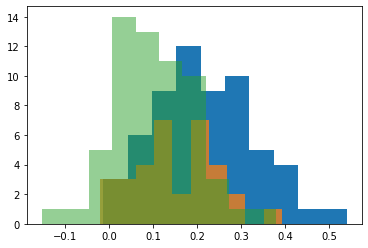

Randoms 350: 0.05318060791766269 +\- 0.0704998183401277
MaDCoWS 350: 0.1633760469423248 +\- 0.09224675816121593
ACT 350: 0.07570313265923671 +\- 0.07942995395822477


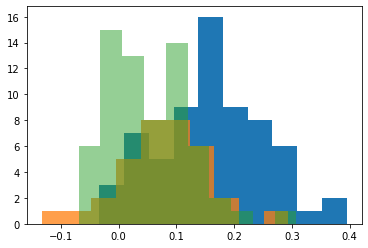

Randoms 500: 0.013675800490361835 +\- 0.049822027669677346
MaDCoWS 500: 0.08575976774178752 +\- 0.056362818506797176
ACT 500: 0.028377667061038368 +\- 0.0655845176327139


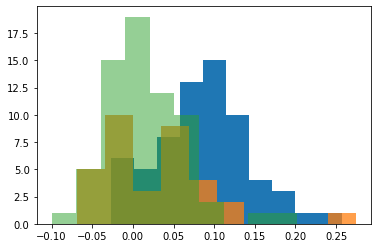

In [9]:
mdcw_stamps = pk.load( open('mdcw_stamps.pk', 'rb'))
randoms_stamps = pk.load( open('randoms_stamps.pk', 'rb'))
act_stamps = pk.load( open('act_stamps.pk', 'rb'))

mdcw_cent_ems = {'250':[], '350':[], '500':[]}
act_cent_ems = {'250':[], '350':[], '500':[]}
rand_cent_ems = {'250':[], '350':[], '500':[]}

beam = 2.4

for key in mdcw_cent_ems.keys():
    stamps = mdcw_stamps[key]
    rand_stamps = randoms_stamps[key]
    for cluster_name in stamps.keys():
        stamp, pixel_size = stamps[cluster_name][0], stamps[cluster_name][1]
        rand_stamp, pixel_size = rand_stamps[cluster_name][0], stamps[cluster_name][1]

        #plt.imshow(stamp)
        #plt.show()
        #plt.close()

        #print(pixel_size)
        em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)

        em_rand, num = central_emission(rand_stamp, 50, pixel_size.value, beam/2)
        em_rand = em_rand*u.Jy
        em_rand = em_rand.to(u.MJy)
        
        pixel_area = (pixel_size)**2
        pixel_area = pixel_area.to(u.sr)

        mean_cent_em = em/(num*pixel_area)
        rand_mean_cent_em = em_rand/(num*pixel_area)


        mdcw_cent_ems[key].append(mean_cent_em.value)
        rand_cent_ems[key].append(rand_mean_cent_em.value)

for key in act_cent_ems.keys():
    stamps = act_stamps[key]
    for cluster_name in stamps.keys():
        stamp, pixel_size = stamps[cluster_name][0], stamps[cluster_name][1]

        #plt.imshow(stamp)
        #plt.show()
        #plt.close()

        #print(pixel_size)
        em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)

        pixel_area = (pixel_size)**2
        pixel_area = pixel_area.to(u.sr)

        mean_cent_em = em/(num*pixel_area)

        act_cent_ems[key].append(mean_cent_em.value)

            
for key in mdcw_cent_ems.keys():
    print('Randoms {}: {} +\- {}'.format(key, np.mean(rand_cent_ems[key]), np.std(rand_cent_ems[key])))
    print('MaDCoWS {}: {} +\- {}'.format(key, np.mean(mdcw_cent_ems[key]), np.std(mdcw_cent_ems[key])))
    print('ACT {}: {} +\- {}'.format(key, np.mean(act_cent_ems[key]), np.std(act_cent_ems[key])))
    plt.hist(np.array(mdcw_cent_ems[key]))
    plt.hist(np.array(act_cent_ems[key]), alpha = 0.75)
    plt.hist(np.array(rand_cent_ems[key]), alpha = 0.5)
    plt.show()

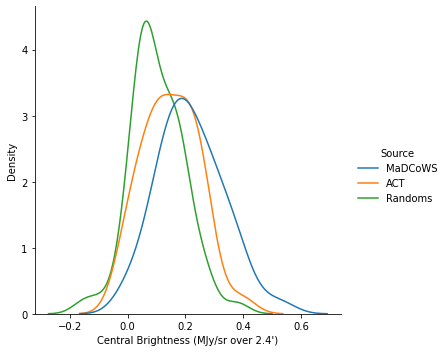

In [34]:
data_250 = mdcw_cent_ems['250']+act_cent_ems['250']+rand_cent_ems['250']
labels = ['MaDCoWS']*len(mdcw_cent_ems['250'])+['ACT']*len(act_cent_ems['250'])+['Randoms']*len(rand_cent_ems['250'])

fordf_250 = [labels, data_250]

df = pd.DataFrame (fordf_250).transpose()
df.columns = ['Source','Central Brightness (MJy/sr over 2.4\')']
df['Central Brightness (MJy/sr over 2.4\')']=df['Central Brightness (MJy/sr over 2.4\')'].astype('float64')

#sns.displot(df, x= 'Central Brightness (MJy/sr over 2.4\')', hue="Source", stat="density", common_norm=False, bins = 20)
sns.displot(df, x='Central Brightness (MJy/sr over 2.4\')', hue = 'Source', kind="kde", common_norm = False)
plt.show()


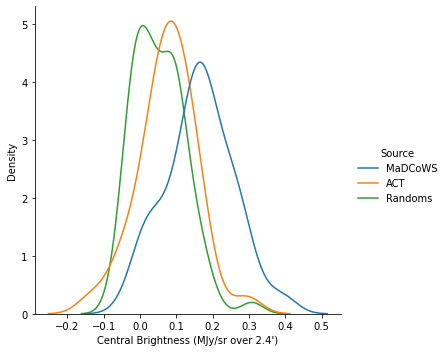

In [35]:
data_350 = mdcw_cent_ems['350']+act_cent_ems['350']+rand_cent_ems['350']
labels = ['MaDCoWS']*len(mdcw_cent_ems['350'])+['ACT']*len(act_cent_ems['350'])+['Randoms']*len(rand_cent_ems['350'])

fordf_350 = [labels, data_350]

df = pd.DataFrame (fordf_350).transpose()
df.columns = ['Source','Central Brightness (MJy/sr over 2.4\')']
df['Central Brightness (MJy/sr over 2.4\')']=df['Central Brightness (MJy/sr over 2.4\')'].astype('float64')

#sns.displot(df, x= 'Central Brightness (MJy/sr over 2.4\')', hue="Source", stat="density", common_norm=False, bins = 20)
sns.displot(df, x='Central Brightness (MJy/sr over 2.4\')', hue = 'Source', kind="kde", common_norm = False)
plt.show()

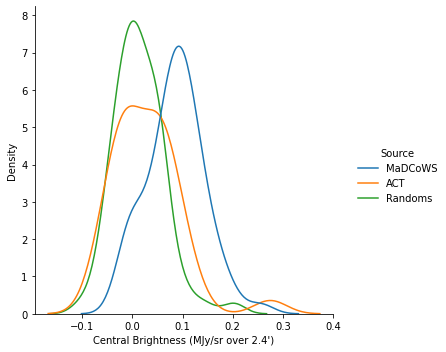

In [36]:

data_500 = mdcw_cent_ems['500']+act_cent_ems['500']+rand_cent_ems['500']
labels = ['MaDCoWS']*len(mdcw_cent_ems['500'])+['ACT']*len(act_cent_ems['500'])+['Randoms']*len(rand_cent_ems['500'])

fordf_500 = [labels, data_500]

df = pd.DataFrame (fordf_500).transpose()
df.columns = ['Source','Central Brightness (MJy/sr over 2.4\')']
df['Central Brightness (MJy/sr over 2.4\')']=df['Central Brightness (MJy/sr over 2.4\')'].astype('float64')

#sns.displot(df, x= 'Central Brightness (MJy/sr over 2.4\')', hue="Source", stat="density", common_norm=False, bins = 20)
sns.displot(df, x='Central Brightness (MJy/sr over 2.4\')', hue = 'Source', kind="kde", common_norm = False)
plt.show()

<Figure size 432x288 with 0 Axes>

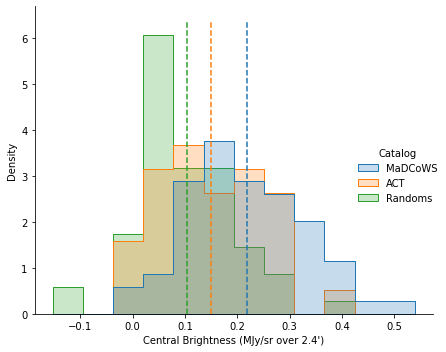

<Figure size 432x288 with 0 Axes>

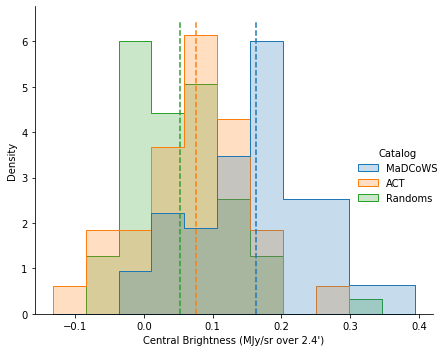

<Figure size 432x288 with 0 Axes>

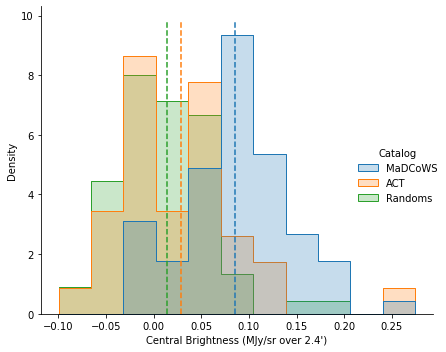

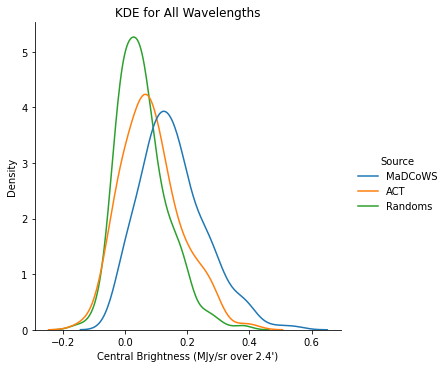

In [62]:
big_data = []
big_labels = []
big_freq = []

#fig = plt.figure()

for i, key in enumerate(mdcw_cent_ems.keys()):
    data = mdcw_cent_ems[key]+act_cent_ems[key]+rand_cent_ems[key]
    labels = ['MaDCoWS']*len(mdcw_cent_ems[key])+['ACT']*len(act_cent_ems[key])+['Randoms']*len(rand_cent_ems[key])
    big_data += data
    big_labels += labels
    big_freq += [key]*(len(mdcw_cent_ems[key])+len(act_cent_ems[key])+len(rand_cent_ems[key]))
    
    fordf = [labels, data]

    df = pd.DataFrame(fordf).transpose()
    df.columns = ['Catalog','Central Brightness (MJy/sr over 2.4\')']
    df['Central Brightness (MJy/sr over 2.4\')']=df['Central Brightness (MJy/sr over 2.4\')'].astype('float64')
    #ax = fig.add_subplot(3, 1, i+1)
    fig = plt.figure()
    
    #KDE no histogram
    #sns.displot(df, x='Central Brightness (MJy/sr over 2.4\')', hue = 'Source', kind = 'kde', common_norm = False)

    #Histogram no KDE
    sns.displot(df, x='Central Brightness (MJy/sr over 2.4\')', hue = 'Catalog',stat="density", common_norm = False, element="step")

    #Very Busy plot
    #sns.displot(df, x='Central Brightness (MJy/sr over 2.4\')', hue = 'Source',stat="density", kde = True, common_norm = False, element="step")
    
    #Plot averages with lines
    ymin, ymax = plt.ylim()
    plt.vlines(x = np.mean(mdcw_cent_ems[key]), ymin = ymin, ymax = ymax, colors = 'tab:blue', linestyles ='dashed')
    plt.vlines(x = np.mean(act_cent_ems[key]), ymin = ymin, ymax = ymax, colors = 'tab:orange', linestyles ='dashed')
    plt.vlines(x = np.mean(rand_cent_ems[key]), ymin = ymin, ymax = ymax, colors = 'tab:green', linestyles ='dashed')
    
    plt.tight_layout()
    
    #plt.title(r'Histogram of Central Brightness at {}$\mu$m'.format(key))
    plt.savefig('./plots/herschel/brightness_hist_{}.png'.format(key), dpi =300)
    plt.savefig('./plots/herschel/brightness_hist_{}.pdf'.format(key))
    plt.show()
    plt.close()

    
big_fordf = [big_freq, big_labels, big_data]
big_df = pd.DataFrame(big_fordf).transpose()
big_df.columns = ['Wavelength (um)','Source','Central Brightness (MJy/sr over 2.4\')']

big_df['Central Brightness (MJy/sr over 2.4\')'] = big_df['Central Brightness (MJy/sr over 2.4\')'].astype('float64')


sns.displot(big_df, x='Central Brightness (MJy/sr over 2.4\')', hue = 'Source', kind="kde", common_norm = False)
plt.title('KDE for All Wavelengths')
plt.savefig('./plots/herschel/full_brightness_kde.png', dpi =300)
plt.savefig('./plots/herschel/full_brightness_kde.pdf')



In [78]:
print(len(mdcw_cent_ems['350']),len(act_cent_ems['350']),len(rand_cent_ems['350']))


66 34 66


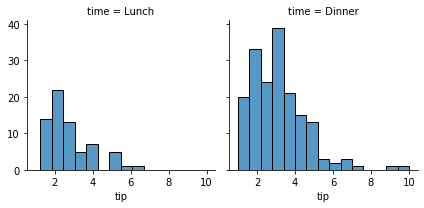